# Drawing and plotting with `polygonsoup`
by Daniel Berio (2022) www.enist.org


[`polygonsoup`](https://github.com/colormotor/polygonsoup/tree/main/py) is a collection of Python utilities for generating and drawing "plotter-firendly" graphics.

## Install the dependencies (first time only)

First make sure that the appropriate environment is selected (above). If you are using py5canvas this should be `py5` (top right of the notebook):

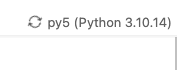


The basic polygonsoup functionalities will work on Collab without any additional requirements. To install run:

In [ ]:
!pip uninstall polygonsoup -y
!pip install git+https://github.com/colormotor/polygonsoup.git#subdirectory=py

The uninstall call is useful in case the polygonsoup package is needs update. This will require restarting the notebook runtime.

Now download some files that are required for the examples:

In [ ]:
!curl -o test.svg https://raw.githubusercontent.com/colormotor/polygonsoup/main/py/examples/test.svg
!curl -o teapot.obj https://raw.githubusercontent.com/colormotor/polygonsoup/main/py/examples/teapot.obj
!curl -o stanford-bunny.obj https://raw.githubusercontent.com/colormotor/polygonsoup/main/py/examples/stanford-bunny.obj


For some of the functionalities it is useful to install some additional packages.  
To perform clipping and boolean operations on polygons, we need [pyclipper](https://pypi.org/project/pyclipper/):

In [ ]:
!pip install pyclipper

To load Scalable Vector Graphics (SVG) files:

In [ ]:
!pip install git+https://github.com/mathandy/svgpathtools.git

Some additional dependencies will be specified later in this document when/if necessary.

## Polygonsoup basics

Plotters can basically do three operations: Move the pen up, move the pen down and move to a given position on the plane. As a result, the "first class" objects in the polygonsoup system are points and polylines. We will call polylines "paths".
Points (and vectors) are NumPy arrays. Most supported operations with polylines are exposed in the `polygonsoup.geom` module. A point can be created with  

In [1]:
import numpy as np
p = np.array([1, 0.5])

Since the `np.array` can get verbose, the `polygonsoup.geom` module exposes a `vec` function, which allows to create a point/vector with:

In [2]:
import polygonsoup.geom as geom
vec = geom.vec
p = vec(1, 0.5)

A path is a sequence of points. It is also represented as a NumPy `ndarray` object having one row for each point. For example:


In [3]:
# A path (polyline)
P = np.array([(0, 0), (1, 0), (1,1), (0, 1), (0, 0)])*100
# or a circle
Q = np.array([vec(np.cos(t), np.sin(t))*200+256 
              for t in np.linspace(0, np.pi*2, 50)])


A list of paths is called a "compound path", it can also be treated as a first class object 

In [4]:
# A compount path (square and circle)
S = [P, Q]

### Creating images

Py5canvas is compatible with the path format used by polygonsoup, and we can visualize a compound path with the `shape` function. For example to visualize the compound path above:

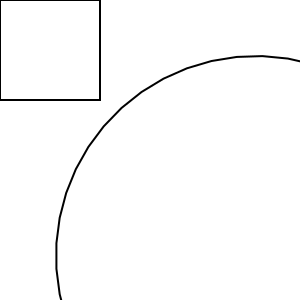

In [5]:
from py5canvas import *
create_canvas(300, 300)
background(255)
no_fill()
stroke(0)
shape(S)
show()

The paths we create might not be correctly resized to fit our canvas. To easily transform them to the desired size we can use the `geom.transform_to_rect` function. Let's wrap it inside a convenience function that we can use later on:

In [6]:
from polygonsoup import geom

def to_canvas(paths, padding=20):
    return geom.transform_to_rect(paths, geom.make_rect(0, 0, width, height), padding)

Now we can easily adapt any shape to fit our canvas (this will be useful later when loading SVGs)

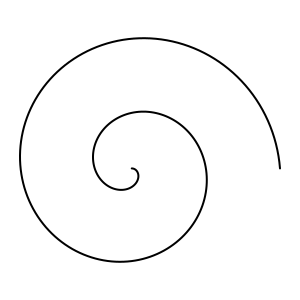

In [7]:
paths = [np.array([[np.cos(t)*t, np.sin(t)*t] for t in np.linspace(0, np.pi*4, 300)])]
create_canvas(300, 300)
background(255)
shape(to_canvas(paths))
show()

## Turtle graphics
One natural way to create graphics for a plotter is the ["Turtle"](https://en.wikipedia.org/wiki/Turtle_graphics) analogy. A turtle has an orientation, it can move forward, backwards and it holds a pen that can be "up" or "down". This idea was pioneered by [Seymour Papert](https://en.wikipedia.org/wiki/Seymour_Papert) in the 60's and is suitable to be implemented with a plotter or more literally with a ["turtle robot"](https://en.wikipedia.org/wiki/Turtle_(robot)). Papert co-developed the LOGO programming language, which can be used to generate vector graphics with a turtle. A typical example of LOGO is the "flower" example, which boils down to:
```
to flower
repeat 36 [right 10 square]
end
```
With the `polygonsoup.turtle` module this is:

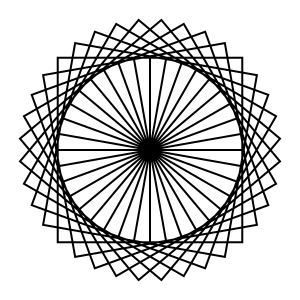

In [8]:
import polygonsoup.turtle as turtle
t = turtle.Turtle()
for i in range(36):
    t.right(10)
    t.square(3) # try: t.circle(3, steps=11)

create_canvas(300, 300)   
background(255)
shape(to_canvas(t.paths, 20))
show()


The [`polygonsoup.turtle.Turtle`](https://github.com/colormotor/polygonsoup/blob/main/py/polygonsoup/turtle.py) class is a slightly modified version of the one provided by Michael Fogelman in [axi](https://github.com/fogleman/axi). Refer to the source file for additional functionalities. 

Go and check <https://turtletoy.net> for some inspiring examples of what can be achieved with a turtle, armed with a pen. The examples are in Javascript, but it should be straight-forward to adapt these to Python.

## Loading SVG

The `polygonsoup.svg` module allows to easily load Scalable Vector Graphics (SVG) files as compound paths and visualize/plot these:

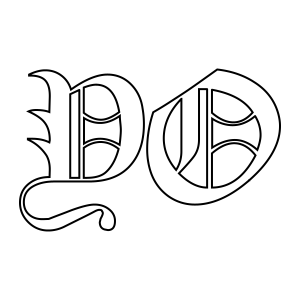

In [9]:
import polygonsoup.svg as svg

S = svg.load_svg('./test.svg')
create_canvas(300, 300)
background(255)
shape(to_canvas(S))
show()

## Filling shapes (hatching)
A plotter cannot "fill" a shape like a normal printer, but a similar effect can be achieved by covering an area with lines through "hatching". This can be done with the `polygonsoup.hatch` module. For example

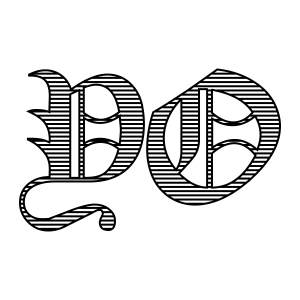

In [10]:
import polygonsoup.hatch as hatch

hatches = hatch.hatch(S, dist=5, angle=0)
create_canvas(300, 300)
background(255)
shape(to_canvas(S+hatches))
show()


Or make it lighter, and diagonal lines with

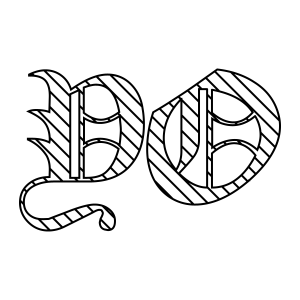

In [11]:
hatches = hatch.hatch(S, dist=13, angle=45)
background(255)
shape(to_canvas(S + hatches))
show()

## Bézier curves

While the `svg.load_svg` returns polylines, paths in SVG files are often represented as piecewise-polynomial curves known as [Bézier curves](https://en.wikipedia.org/wiki/Bézier_curve). This [link](https://pomax.github.io/bezierinfo/) is a great reference for this type of curves, which are widely used in Computer Aided Design (CAD) applications. The `polygonsoup.bezier` module exposes utilities to generate a single Bézier curve:

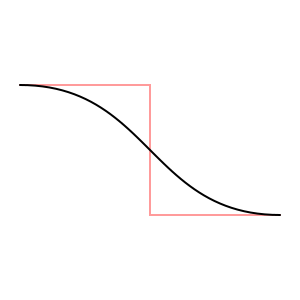

In [12]:
import polygonsoup.bezier as bez # This conflicts with the py5canvas bezier function if called `bezier`

Cp = to_canvas(np.array([[0, 0], [0.5, 0], [0.5, 0.5], [1, 0.5]]))
P = bez.bezier(Cp, np.linspace(0, 1, 50))

background(255)
# Display control polygon
stroke(255, 0, 0, 100)
polyline(Cp)
# Display curve
stroke(0)
polyline(P)
show()


In this case the curve is cubic (the most widely used case) and it is defined with a *control polygon* consisting of 4 points. The control polygon is often visualised as an initial and final point interpolated by the curve, each connected with "handles" to two intermediate control points. The intermediate control points define the tangents and the velocity at the endpoints of the curve.

A *piecewise* Bézier curve is defined with a series of consecutive Bézier curve segments, where each segment shares a control point with the subsequent one. For the cubic case, a piecwise curve with $N$ segments requires $3N+1$ control points. We can create a polyline for a piecewise curve with the `bezier.bezier_piecewise` function: 

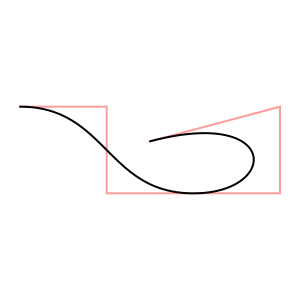

In [13]:
create_canvas(300, 300)

Cp = to_canvas(np.array([[0, 0], [0.5, 0], [0.5, 0.5], [1, 0.5],
                             [1.5, 0.5], # Forces continuity
                             [1.5, 0.], [0.75, 0.2]]))
P = bez.bezier_piecewise(Cp, subd=100)

background(255)
no_fill()
# Display control polygon
stroke(255, 0, 0, 100)
polyline(Cp)
# Display curve
stroke(0)
polyline(P)
show()


and adjusting the intermediate control points allows to achieve a continuous curve. 

If we want to always have continous curves, we can use a different curve representation that can be converted to Bézier form. One popular one is the "Catmull-Rom spline". It is also used in P5js, as well as Py5Canvas, to create curves with the `curve` function. We can construct the Bezier control points from catmull-rom ones with a intermediate function:



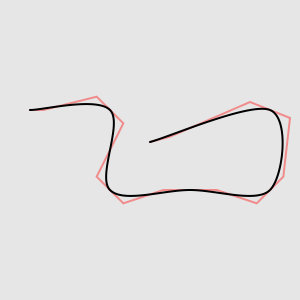

In [14]:
from importlib import reload
reload(bez)

create_canvas(300, 300)

Q = to_canvas(np.array([[0, 0], [0.5, 0], [0.5, 0.5], [1, 0.5],
                             [1.5, 0.5], 
                             [1.5, 0.], [0.75, 0.2]]), 30)
Cp = bez.catmull_rom_to_bezier(Q)
P = bez.bezier_piecewise(Cp, subd=100)

background(230)
no_fill()
# Display control polygon
stroke(255, 0, 0, 100)
polyline(Cp)
# Display curve
stroke(0)
polyline(P)
show()

# Other curves
Any other curve definied in parametric form can be easily transformed into a polygonal representation. The following is an example based on a [Lissajous curve](http://paulbourke.net/geometry/harmonograph/) that models the motion of two swinging masses (a Harmonograph). 


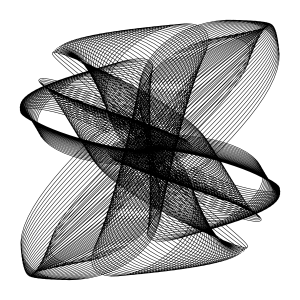

In [15]:
def lissajous(t, a, b, omega, delta):
    return np.vstack([a*np.cos(omega*t + delta),
                      b*np.sin(t)]).T

def lissajous_shape():
    n = 300
    S = []

    t = np.linspace(0, np.pi*2, n)

    delta = np.random.uniform(-np.pi/2, np.pi/2)
    da = np.random.uniform(-np.pi/2, np.pi/2)
    db = np.random.uniform(-np.pi/2, np.pi/2)
    omega = 3
    for o in np.linspace(0, 2.0, 35):
        a = np.sin(np.linspace(0, np.pi*8, n) + da + o*0.5)*100
        b = np.cos(np.linspace(0, np.pi*8, n) + db + o*1.0)*100
        P = lissajous(t, a,
                         b,
                         omega,
                         delta)
        S.append(P)
    return S

S = to_canvas(lissajous_shape())
background(255)
stroke_weight(0.5) # <- make strokes thinner
shape(S)
show()


Paul Bourke has a great [website](http://paulbourke.net), which contains formulas for many [parametric curves](http://paulbourke.net/geometry/) as well as many other useful computer graphics resources.  

## Clipping and boolean operations

Because the plotter can just draw lines, it can be useful to "clip" these lines or perform [boolean operations](https://en.wikipedia.org/wiki/Boolean_operations_on_polygons) (e.g. union, difference, intersection) on paths. Take for example two circles and a random polyline. We generate the circle paths with the `geom.shapes` utility, which contains other simple shapes that can be plotted as well:

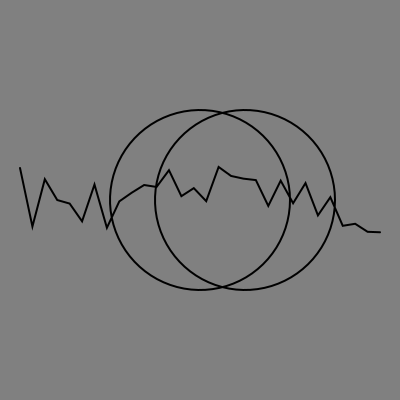

In [19]:
from polygonsoup.geom import shapes

# Two circles
S = [shapes.circle(vec(0, 0), 10), shapes.circle(vec(5, 0), 10)]
# A random polyline
n = 30
P = np.vstack([np.linspace(-20, 20, n),
               np.random.uniform(-4, 4, n)]).T

create_canvas(400, 400)
no_fill()
shape(to_canvas(S + [P]))
show()
# Alternative (no py5canvas)
# from polygonsoup import plut
# plut.figure()
# plut.stroke(S + [P], 'k')
# plut.show()


Let's say we want to hide the polyline behind the union of the two circles and emphasise the area of the intersection between the circles. We use the `polygonsoup.clipper` module with:

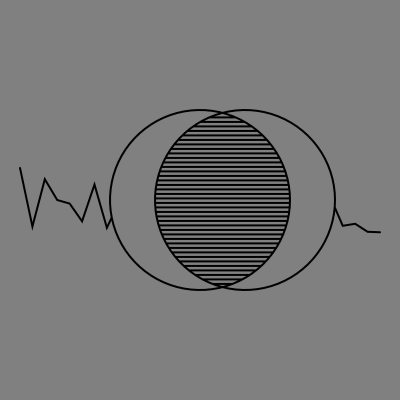

In [21]:
import polygonsoup.clipper as clip

# Hatch intersection
Si = clip.intersection(S[0], S[1])
hatches = hatch.hatch(Si, 0.5)
# Clip a polyline with the two circles
Pclip = clip.difference(P, S, False, True) # Flag P as open

create_canvas(400, 400)
no_fill()
shape(to_canvas(S + Pclip + hatches))
show()

# plut.figure()
# plut.stroke(S + [Pclip] + hatches, 'k')
# plut.show()


See the [polygonsoup.clipper](https://github.com/colormotor/polygonsoup/blob/main/py/polygonsoup/clipper.py) source for the available operations. The file wraps the powerful [Clipper](http://www.angusj.com/delphi/clipper/documentation/Docs/Overview/_Body.htm) library by Angus Johnson. By default paths are considered to be closed, but the functions contain flags that can be used to indicate that a path is open (e.g. see the operation that produces `Pclip` above).



## Some relevant links

The following are some relevant links, some for reference, some for inspiration.

### Axidraw related links 
- [AxiDraw V3 manual](https://cdn.evilmadscientist.com/wiki/axidraw/software/AxiDraw_V37r1.pdf)
- [AxiDraw control Python package](https://github.com/fogleman/axi)
- [AxiDraw Server](https://lurkertech.com/axiserver/)
- [Smooth pen up/down movement hack](https://lurkertech.com/3daxi/) extension to smoothly control pen pressure. 

### Python, useful packages (for generating drawings etc.)
- [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) Good library for manipulating gemetry, originally aimed at GIS (Geographical Information Systems) but can be useful for art-related applications as well.
- [NetworkX](https://networkx.github.io) Nice Graph library for Python. Includes many [algorithms](https://networkx.org/documentation/stable/reference/algorithms/index.html) that can be used to generate graphics.
- [SciPy](https://www.scipy.org) Generally useful as an addition to NumPy. Has wrappers to generate [Voronoi diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram), [Delaunay triangulations](https://en.wikipedia.org/wiki/Delaunay_triangulation) and a useful [smoothing spline implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html).
- [The visualization toolkit (VTK)](https://vtk.org) Powerful geometry processing library, that can be used in combination with the [polygonsoup](https://github.com/colormotor/polygonsoup/tree/main/py) package.
- [fonttools](https://github.com/fonttools/fonttools) Useful to load TrueType font files
- [scikit-geometry](https://github.com/scikit-geometry/scikit-geometry) Provides a Python interface for the the powerful [Computational Geometry Algorithms Library (CGAL)](https://www.cgal.org).
-  [OpenCV](https://opencv.org) For image processing, has Python bindings that are easy to integrate with NumPy.
- [PyCairo](https://pycairo.readthedocs.io/en/latest/) For 2d vector graphics.

### Other languages, tools useful for AxiDraw
- [Pbdlib](https://calinon.ch/codes.htm) Sylvain Calinon has open source code that can be easily adapted to generate drawings with AxiDraw.
- [processing](https://processing.org) is a wrapper around Java intended to facilitate "sketching" of graphic ideas. 
  - <https://www.generativehut.com/post/axidraw-processing> This is a link explains how to interface processing with AxiDraw.
- <https://p5js.org> a JavaScript version of Processing.
- <http://paperjs.org> a powerful javascript library for 2d vector graphics.
- <https://turtletoy.net> a online JavaScript library and coding sandbox with many examples that are extremely plotter-friendly.
- <https://github.com/fogleman/ln> a line-based 3d renderer written in Go. Very powerful, based on signed distance fields.
- <http://hackingforartists.com> many more links to explore that are not listed here.
  
### Curves and surfaces
- <http://paulbourke.net/geometry> Paul Bourkes' website. Full of formulas/code examples
- Euler spirals (or Cornu Spirals, or clothoids), a presentation by Raph Levien <https://www2.eecs.berkeley.edu/Pubs/TechRpts/2008/EECS-2008-111.pdf>. Can be generated with the Fresnel integrals, which are implemented in [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.fresnel.html)
- Online primer/book on Bézier curves: <https://pomax.github.io/bezierinfo/>
  
### Graphics/Geometry
- <https://www.jasondavies.com> has a collection of nice Javasript demos with computational geometry algorithms.
- <http://jeffe.cs.illinois.edu/compgeom/code.html> a nice collection of computational geometry codes in C/C++.
- A tutorial on Hexagonal grids: <http://www-cs-students.stanford.edu/~amitp/Articles/HexLOS.html>
- [Tech notes](https://www.glassner.com/writing/tech-notes/) by Andrew Glassner
- [Ken Perlin's home page](https://cs.nyu.edu/~perlin/) has many nice interactive examples (beautifully) written in Java.
- <http://hackingforartists.com> A resource with different links that
  can be handy for generating drawings.

### Contemporary artists using AxiDraw, plotters, robots
- [Michael Fogleman](https://www.michaelfogleman.com) who wrote the Axi library.
- [Joanie Lemercier](https://joanielemercier.com), video/media artist.
- [Frederik Vanhoutte](https://twitter.com/wblut), who also has some useful online code <https://github.com/wblut>.
- [Jurg Lehni](http://juerglehni.com) font-designer, author of Paper.js and builder of some really nice custom built plotters.
- [Patrick Tresset](https://patricktresset.com/new/) is a contemporary artist that works with low-cost robot arms and plotters.
- I have built and worked with a number of plotters (custom built an non): https://www.enist.org/post/drawing_machines/.
  
### Early computer art and artists using plotters (for inspiration)
- [The Algorists](http://www.verostko.com/algorist.html), article by Roman Verotsko 
- <http://computer-arts-society.com/cas50-collection>
- [Artist and Computer digital book](https://www.atariarchives.org/artist/)
- [Manfred Mohr](https://www.emohr.com)
- [Roman Verotsko](http://www.verostko.com)
- [Cybernetic serendipity](http://cyberneticserendipity.net) exhibition.
- [Cybernetic serendipity book (online flipbook)](https://www.studiointernational.com/flipbookCyberneticSerendipity/StudioInternationalCyberneticSerendipity-1968.html)
- [Short article on computer art history](http://www.vam.ac.uk/content/articles/a/computer-art-history/)
- [Plotter drawings at the V&A](http://collections.vam.ac.uk/search/?id_technique=x43893)


